#Loading dataset 

In [1]:
import pandas as pd 
import numpy as np
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.metrics import roc_auc_score, auc, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable as pt
from sklearn.model_selection import train_test_split
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
train = pd.read_csv('pre_bal_train2.csv')

In [6]:
cols_l = train.columns
cols_l = cols_l.to_list()

In [7]:
cols_l.remove('isFraud')
cols_l.remove('uid')

In [8]:
percent_missing = train.isnull().sum() * 100 / len(train)                        #calculating percentage missing values in columns and then making a dataframe from it
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})

In [9]:
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)

In [10]:
missing_value_df[:15]    #missing values in all the standard deviation calculated features

,column_name,percent_missing
C14std,C14std,0.001693
V318std,V318std,0.001693
V45std,V45std,0.001693
C13std,C13std,0.001693
C1std,C1std,0.001693
V40std,V40std,0.001693
C7std,C7std,0.001693
V79std,V79std,0.001693
C2std,C2std,0.001693
V317std,V317std,0.001693


In [11]:
rev = []
for yt in range(len(missing_value_df)):
     if missing_value_df['percent_missing'][yt] != 0:
        rev.append(missing_value_df['column_name'][yt])

In [12]:
cols_l = list(set(cols_l) - set(rev))         #removing columns containing missing values

In [13]:
trai = train[cols_l].astype(float)

#Splitting the dataset

In [14]:
train_x, test_x, train_y, test_y = train_test_split(trai.values, train['isFraud'].values, test_size=0.2)

In [15]:
sec_train_x, sec_test_x, sec_train_y, sec_test_y = train_test_split(train_x, train_y, test_size=0.5)

#Generating Samples and training base learners


In [16]:
def generating_samples(input_data, target_data):
    sample_row = np.random.choice(len(input_data) , int(0.6 * len(input_data)) , replace=False)
    gen_row = np.random.choice(sample_row, int(0.4 * len(input_data)), replace = False)
    gen_row = np.sort(gen_row)
    sample_row = np.sort(sample_row)
    col_n = np.sort(np.random.choice(input_data.shape[1],size=input_data.shape[1],replace =False))
    sample_data = input_data[sample_row[:,None],col_n]
    target_sample_data = target_data[sample_row]

    rep_sample_data = input_data[gen_row[:,None],col_n]
    rep_target_sample_data = target_data[gen_row]

    final_sample_data = np.vstack((sample_data,rep_sample_data))
    final_target_data = np.vstack((target_sample_data.reshape(-1,1), rep_target_sample_data.reshape(-1,1)))

    return final_sample_data, final_target_data

In [20]:
def training_base(data_x, data_y, k):
   list_of_models = []
   for i in range(0,k):
     if k % 2 == 0:
       a,b=generating_samples(data_x,data_y)
       model = xgboost.XGBClassifier(
            n_estimators=1000,
            max_depth=11,
            learning_rate=0.02,
            colsample_bytree=0.4,
            eval_metric='auc', 
          )
       model.fit(a,b)
       list_of_models.append(model)
     if k % 2 == 1:
       a,b=generating_samples(data_x,data_y)
       model1 = GaussianNB()
       model1.fit(a,b)
       list_of_models.append(model1)

   return list_of_models

In [21]:
list_of_models = training_base(sec_train_x, sec_train_y, 4)

#Predicting with base learners and training metamodel

In [22]:
def prediction_dataset(list_of_models, sec_test_x):
  all_pred = []
  for tt in range(len(list_of_models)):
     predict = list_of_models[tt].predict(sec_test_x)
     all_pred.append(predict)
     
  final_pred = np.stack(all_pred, axis=1)
  return final_pred

In [23]:
def meta_train(list_of_models, sec_test_x, sec_test_y):
    final_pred = prediction_dataset(list_of_models, sec_test_x)
    metamodel = xgboost.XGBClassifier(
            n_estimators=1000,
            max_depth=11,
            learning_rate=0.02,
            colsample_bytree=0.4,
            eval_metric='auc')
    metamodel.fit(final_pred, sec_test_y)
    return metamodel

In [24]:
metamodel = meta_train(list_of_models, sec_test_x, sec_test_y)

#Predicting with Metamodel

In [25]:
def meta_predict(list_of_models, sec_test_x, metamodel):
    final_pred = prediction_dataset(list_of_models, sec_test_x)
    pred_fin = metamodel.predict(final_pred)
    return pred_fin

In [26]:
meta_prediction = meta_predict(list_of_models, test_x, metamodel)

#Final results

In [27]:
fone = f1_score(test_y, meta_prediction, average=None)
fone

array([0.98977153, 0.61244649])

[]

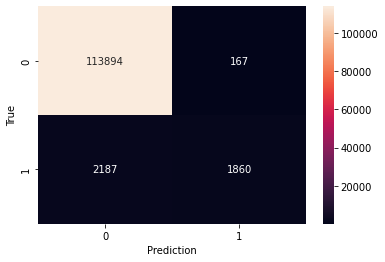

In [28]:
en_confusion = confusion_matrix(test_y, meta_prediction)
sns.heatmap(en_confusion, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.plot()